In [43]:
clear
close all 
addpath(genpath('Github/SSIT/src'));
addpath(genpath('Github/SSIT/WorkSpace/JackModel/Model'))

In [ ]:
% Simulate: Theta = kon
makePlot = false;

N=10;

NCells = 2000;
kon = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1];
koff = 7.5e-5;
w = 0.0025;
kex = 750;
kr = 7.5e4;
D = [0.01,5,4];
gam =[0.035;0.0025;0.001];

disp('Simulating kon')
if false
    results = cell([length(kon), N]);
    for i = 1:length(kon)
        for n = 1:N
            disp(['Simulating n = ' num2str(n) ', kon = ' num2str(kon(i))])
            results{i,n} = Simulate(kon(i), koff, w, kex, kr, D, gam, NCells, makePlot);
        end
    end
    save("Kon", "results")
end

results = load("Kon.mat", "results").results;

Simulating kon
Simulating n = 1, kon = 1e-05
Simulating n = 2, kon = 1e-05
Simulating n = 3, kon = 1e-05
Simulating n = 4, kon = 1e-05
Simulating n = 5, kon = 1e-05
Simulating n = 6, kon = 1e-05
Simulating n = 7, kon = 1e-05
Simulating n = 8, kon = 1e-05
Simulating n = 9, kon = 1e-05
Simulating n = 10, kon = 1e-05
Simulating n = 1, kon = 0.0001
Simulating n = 2, kon = 0.0001
Simulating n = 3, kon = 0.0001
Simulating n = 4, kon = 0.0001
Simulating n = 5, kon = 0.0001
Simulating n = 6, kon = 0.0001
Simulating n = 7, kon = 0.0001
Simulating n = 8, kon = 0.0001
Simulating n = 9, kon = 0.0001
Simulating n = 10, kon = 0.0001
Simulating n = 1, kon = 0.001
Simulating n = 2, kon = 0.001
Simulating n = 3, kon = 0.001
Simulating n = 4, kon = 0.001
Simulating n = 5, kon = 0.001
Simulating n = 6, kon = 0.001
Simulating n = 7, kon = 0.001
Simulating n = 8, kon = 0.001
Simulating n = 9, kon = 0.001
Simulating n = 10, kon = 0.001
Simulating n = 1, kon = 0.01
Simulating n = 2, kon = 0.01
Simulating n =

In [78]:
distances = zeros(n, n, length(kon), length(kon));

for j = 1:length(kon)
    for k = 1:length(kon)
        for n = 1:N
            for n_1 = 1:N
                distances(n, n_1, j, k) = DistributionDistance(results{j,n}, results{k,n_1});
            end
        end
    end
end

function P = Prob(results, edges)
    if nargin < 2 || isempty(edges)
        edges = [0,10,20,30,40,50,60,70,80,90,100];
    end

    RNACountBins = results.binCounts; 
    TSbins = results.binTS;

    P = cell([7, size(RNACountBins, 1)]);

    for ibinloc = 1:5
        iCellsInTSBin = (TSbins == ibinloc);
        for iBin = 1:size(RNACountBins, 1)
            data = RNACountBins(iBin, iCellsInTSBin);
            if isempty(data)
                pdf = zeros(1, length(edges)-1);
            else
                pdf = histcounts(data, 'BinEdges', edges, 'Normalization', 'probability');
            end
            P{ibinloc, iBin} = pdf; % pdf of bined TS 
        end
    end

    iCellsInTSBin = (TSbins == 0);
    for iBin = 1:size(RNACountBins, 1)
        data = RNACountBins(iBin, iCellsInTSBin);
        if isempty(data)
            pdf = zeros(1, length(edges)-1);
        else
            pdf = histcounts(data, 'BinEdges', edges, 'Normalization', 'probability');
        end
        P{6, iBin} = pdf;  % pdf of unknown ts sites
    end

    for iBin = 1:size(RNACountBins, 1)
        data = RNACountBins(iBin, :);
        if isempty(data)
            pdf = zeros(1, length(edges)-1);
        else
            pdf = histcounts(data, 'BinEdges', edges, 'Normalization', 'probability');
        end
        P{7, iBin} = pdf; % pdf of all cells regardless of TS
    end
end

function d = Wasserstein1D(P, Q, binCenters)
    % 1D Wasserstein (Earth Mover's) distance
    cdfP = cumsum(P);
    cdfQ = cumsum(Q);
    d = sum(abs(cdfP - cdfQ) .* diff([0 binCenters]));
end

function d = JSDivergence(P, Q)
    epsilon = 1e-12;
    P = P + epsilon;
    Q = Q + epsilon;

    P = P / sum(P);
    Q = Q / sum(Q);

    M = 0.5 * (P + Q);
    d = 0.5 * sum(P .* log2(P ./ M)) + 0.5 * sum(Q .* log2(Q ./ M));
end

function metric = DistributionDistance(results1, results2, edges)

    if nargin < 3 || isempty(edges)
        allData = [results1.binCounts(:); results2.binCounts(:)];
        edges = linspace(min(allData), max(allData), 21);
    end

    binCenters = edges(1:end-1) + diff(edges)/2;

    P = Prob(results1, edges);
    Q = Prob(results2, edges);

    % Compare overall RNA count distribution
    data1 = sum(results1.binCounts, 1);
    data2 = sum(results2.binCounts, 1);

    pdf1 = histcounts(data1, edges, 'Normalization', 'probability');
    pdf2 = histcounts(data2, edges, 'Normalization', 'probability');

    countDistance = Wasserstein1D(pdf1, pdf2, binCenters);

    distances = zeros(size(P));
    for i = 1:size(P,1)
        for j = 1:size(P,2)
            p = P{i,j};
            q = Q{i,j};

            % Pad if necessary
            if isempty(p); p = zeros(1, length(binCenters)); end
            if isempty(q); q = zeros(1, length(binCenters)); end

            p = p / sum(p + eps);
            q = q / sum(q + eps);

            distances(i,j) = Wasserstein1D(p, q, binCenters);
        end
    end

    metric = countDistance + sum(distances(7,:));
end

In [ ]:
distances(1,1,1,2)

ans = 113.7480

In [83]:
mean_distances = zeros(length(kon), length(kon));

for j = 1:length(kon)
    for k = 1:length(kon)
        distances_ = distances(:,:,j,k);
        distances_ = distances_(~eye(size(distances_)));
        mean_distances(j,k) = mean(distances_);
    end
end

In [ ]:
overlap = zeros(length(kon), length(kon));
for j = 1:length(kon)
    self_distances = distances(:,:,j,j);
    self_distances = self_distances(~eye(size(self_distances)));

    for k = 1:length(kon)
        deviant_distance = distances(:,:,j,k);
        deviant_distance = deviant_distance(~eye(size(deviant_distance)));

        overlap(j,k) = compute_overlap_area(deviant_distance, self_distances);
    end
end

function [overlap_area] = compute_overlap_area(samples1, samples2)
    % Step 1: Define common x range
    x_min = min([samples1; samples2]);
    x_max = max([samples1; samples2]);
    x = linspace(x_min, x_max, 1000);  % Common evaluation points

    % Step 2: Estimate PDFs using KDE
    [pdf1, x1] = ksdensity(samples1, x);
    [pdf2, x2] = ksdensity(samples2, x);

    % Step 3: Compute pointwise minimum
    min_pdf = min(pdf1, pdf2);

    % Step 4: Integrate overlap area
    overlap_area = trapz(x, min_pdf);
end

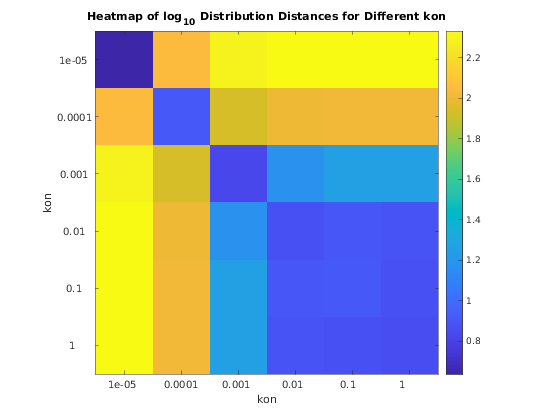

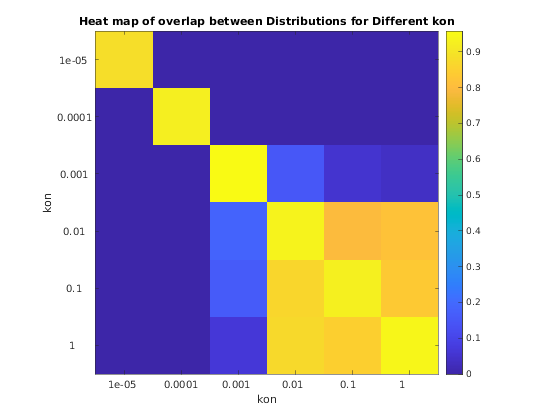

In [90]:
figure;
imagesc(log10(mean_distances));
colorbar;
xlabel('kon');
ylabel('kon');
title('Heatmap of log_{10} Distribution Distances for Different kon');
set(gca, 'XTick', 1:length(kon), 'XTickLabel', kon, ...
         'YTick', 1:length(kon), 'YTickLabel', kon);
axis square;

figure;
imagesc(overlap);
colorbar;
xlabel('kon');
ylabel('kon');
title('Heat map of overlap between Distributions for Different kon');
set(gca, 'XTick', 1:length(kon), 'XTickLabel', kon, ...
         'YTick', 1:length(kon), 'YTickLabel', kon);
axis square;